# Multi-Factor Models

## Implementing the CAPM in Python

In [1]:
# importing neccessary libraries

import warnings
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas_datareader.data as web
import matplotlib.pyplot as plt

# Set plotting style and configurations
plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') # alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\USER\AppData\Local\Temp\ipykernel_29944\2129409711.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


2. Specify the risky asset and the time horizon:

In [2]:
RISKY_ASSET = 'AMZN'
MARKET_BENCHMARK = '^GSPC'
START_DATE = '2014-01-01'
END_DATE = '2018-12-31'

3. Download data from Yahoo Finance:

In [3]:
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                start=START_DATE,
                end=END_DATE,
                progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 1257 rows of data.


4. Resample to monthly data and calculate simple returns:

In [4]:
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset', 
                                    MARKET_BENCHMARK: 'market'}) \
                   .resample('M') \
                   .last() \
                   .pct_change() \
                   .dropna()

X.head()

Ticker,asset,market
Date,,
2014-02-28,0.009507,0.043117
2014-03-31,-0.071058,0.006932
2014-04-30,-0.095847,0.006201
2014-05-31,0.027685,0.021030
2014-06-30,0.039130,0.019058


5. Calculate beta using the covariance approach: 

In [5]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance
beta

1.6296082618965537

6. Prepare the input and estimate CAPM as a linear regression:

In [6]:
# separate target
y = X.pop('asset')

# add constant
X = sm.add_constant(X)

# define and fit the regression model 
capm_model = sm.OLS(y, X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     32.77
Date:                Thu, 06 Jun 2024   Prob (F-statistic):           4.05e-07
Time:                        15:41:21   Log-Likelihood:                 75.313
No. Observations:                  59   AIC:                            -146.6
Df Residuals:                      57   BIC:                            -142.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0178      0.009      1.950      0.0

## Implementing the Fama-French three-factor model in Python

2. Define parameters:

In [7]:
RISKY_ASSET = 'META'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

3. Load data from the source CSV file and keep only the monthly data:

In [8]:
# load data from csv
factor_df = pd.read_csv('Research_Data_Factors.csv', skiprows=3)

# identify where the annual data starts
STR_TO_MATCH = ' Annual Factors: January-December '
indices = factor_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_df[indices].index[0]

# keep only monthly data
factor_df = factor_df[factor_df.index < start_of_annual]

4. Rename columns of the DataFrame, set a datetime index and filter by dates:

In [9]:
# rename columns
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']

# convert strings to datetime
factor_df['date'] = pd.to_datetime(factor_df['date'], 
                                  format='%Y%m') \
                        .dt.strftime("%Y-%m")

# set index
factor_df = factor_df.set_index('date')

# filter only required dates
factor_df = factor_df.loc[START_DATE:END_DATE]

5. Convert the values to numeric and divide by 100:

In [10]:
factor_df = factor_df.apply(pd.to_numeric, 
                           errors='coerce') \
                    .div(100)
factor_df.head()

,mkt,smb,hml,rf
date,,,,
2014-01,-0.0332,0.0085,-0.0209,0.0
2014-02,0.0465,0.0034,-0.0040,0.0
2014-03,0.0043,-0.0189,0.0509,0.0
2014-04,-0.0019,-0.0424,0.0114,0.0
2014-05,0.0206,-0.0186,-0.0027,0.0


6. Download the prices of the risky asset:

In [11]:
asset_df = yf.download(RISKY_ASSET,
                      start=START_DATE,
                      end=END_DATE,
                      progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1258 rows of data.


7. Calculate monthly returns on the risky asset:

In [12]:
y = asset_df['Adj Close'].resample('M') \
                        .last() \
                        .pct_change() \
                        .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'rtn'
y.head()

Date
2014-01    0.144922
2014-02    0.094135
2014-03   -0.120070
2014-04   -0.007636
2014-05    0.058883
Name: rtn, dtype: float64

8. Merge the datasets and calculate excess returns:

In [13]:
ff_data = factor_df.join(y)
ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf

9. Estimate the three-factor model:

In [14]:
# define and fit the regression model 
ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', 
                  data=ff_data).fit()

# print results 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     5.175
Date:                Thu, 06 Jun 2024   Prob (F-statistic):            0.00316
Time:                        15:41:22   Log-Likelihood:                 88.392
No. Observations:                  60   AIC:                            -168.8
Df Residuals:                      56   BIC:                            -160.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0105      0.008      1.373      0.1

## Implementing the rolling three-factor model on a portfolio of assets

In [15]:
# Constants
ASSETS = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = '2009-12-31'
END_DATE = '2018-12-31'

# Download Fama-French three-factor data
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=START_DATE)[0]
df_three_factor = df_three_factor.div(100)
df_three_factor.index = df_three_factor.index.format()

# Download asset data
asset_df = yf.download(ASSETS, start=START_DATE, end=END_DATE, progress=False)

# Output the result of the download
print(f'Downloaded {asset_df.shape[0]} rows of data for {len(ASSETS)} assets from {START_DATE} to {END_DATE}.')

Downloaded 2264 rows of data for 4 assets from 2009-12-31 to 2018-12-31.


5. Calculate the monthly returns on the risky assets:

In [16]:
asset_df = asset_df['Adj Close'].resample('M') \
                                .last() \
                                .pct_change() \
                                .dropna()

# reformat index for joining
asset_df.index = asset_df.index.strftime('%Y-%m')

6. Calculate the portfolio returns:

In [17]:
asset_df['portfolio_returns'] = np.matmul(asset_df[ASSETS].values, 
                                         WEIGHTS)
asset_df.head()

Ticker,AAPL,AMZN,GOOG,MSFT,portfolio_returns
Date,,,,,
2010-01,-0.088597,-0.067722,-0.145230,-0.075459,-0.094252
2010-02,0.065396,-0.055897,-0.005925,0.022146,0.006430
2010-03,0.148470,0.146706,0.076538,0.021626,0.098335
2010-04,0.111022,0.009796,-0.073036,0.042677,0.022615
2010-05,-0.016125,-0.084902,-0.076222,-0.151394,-0.082161


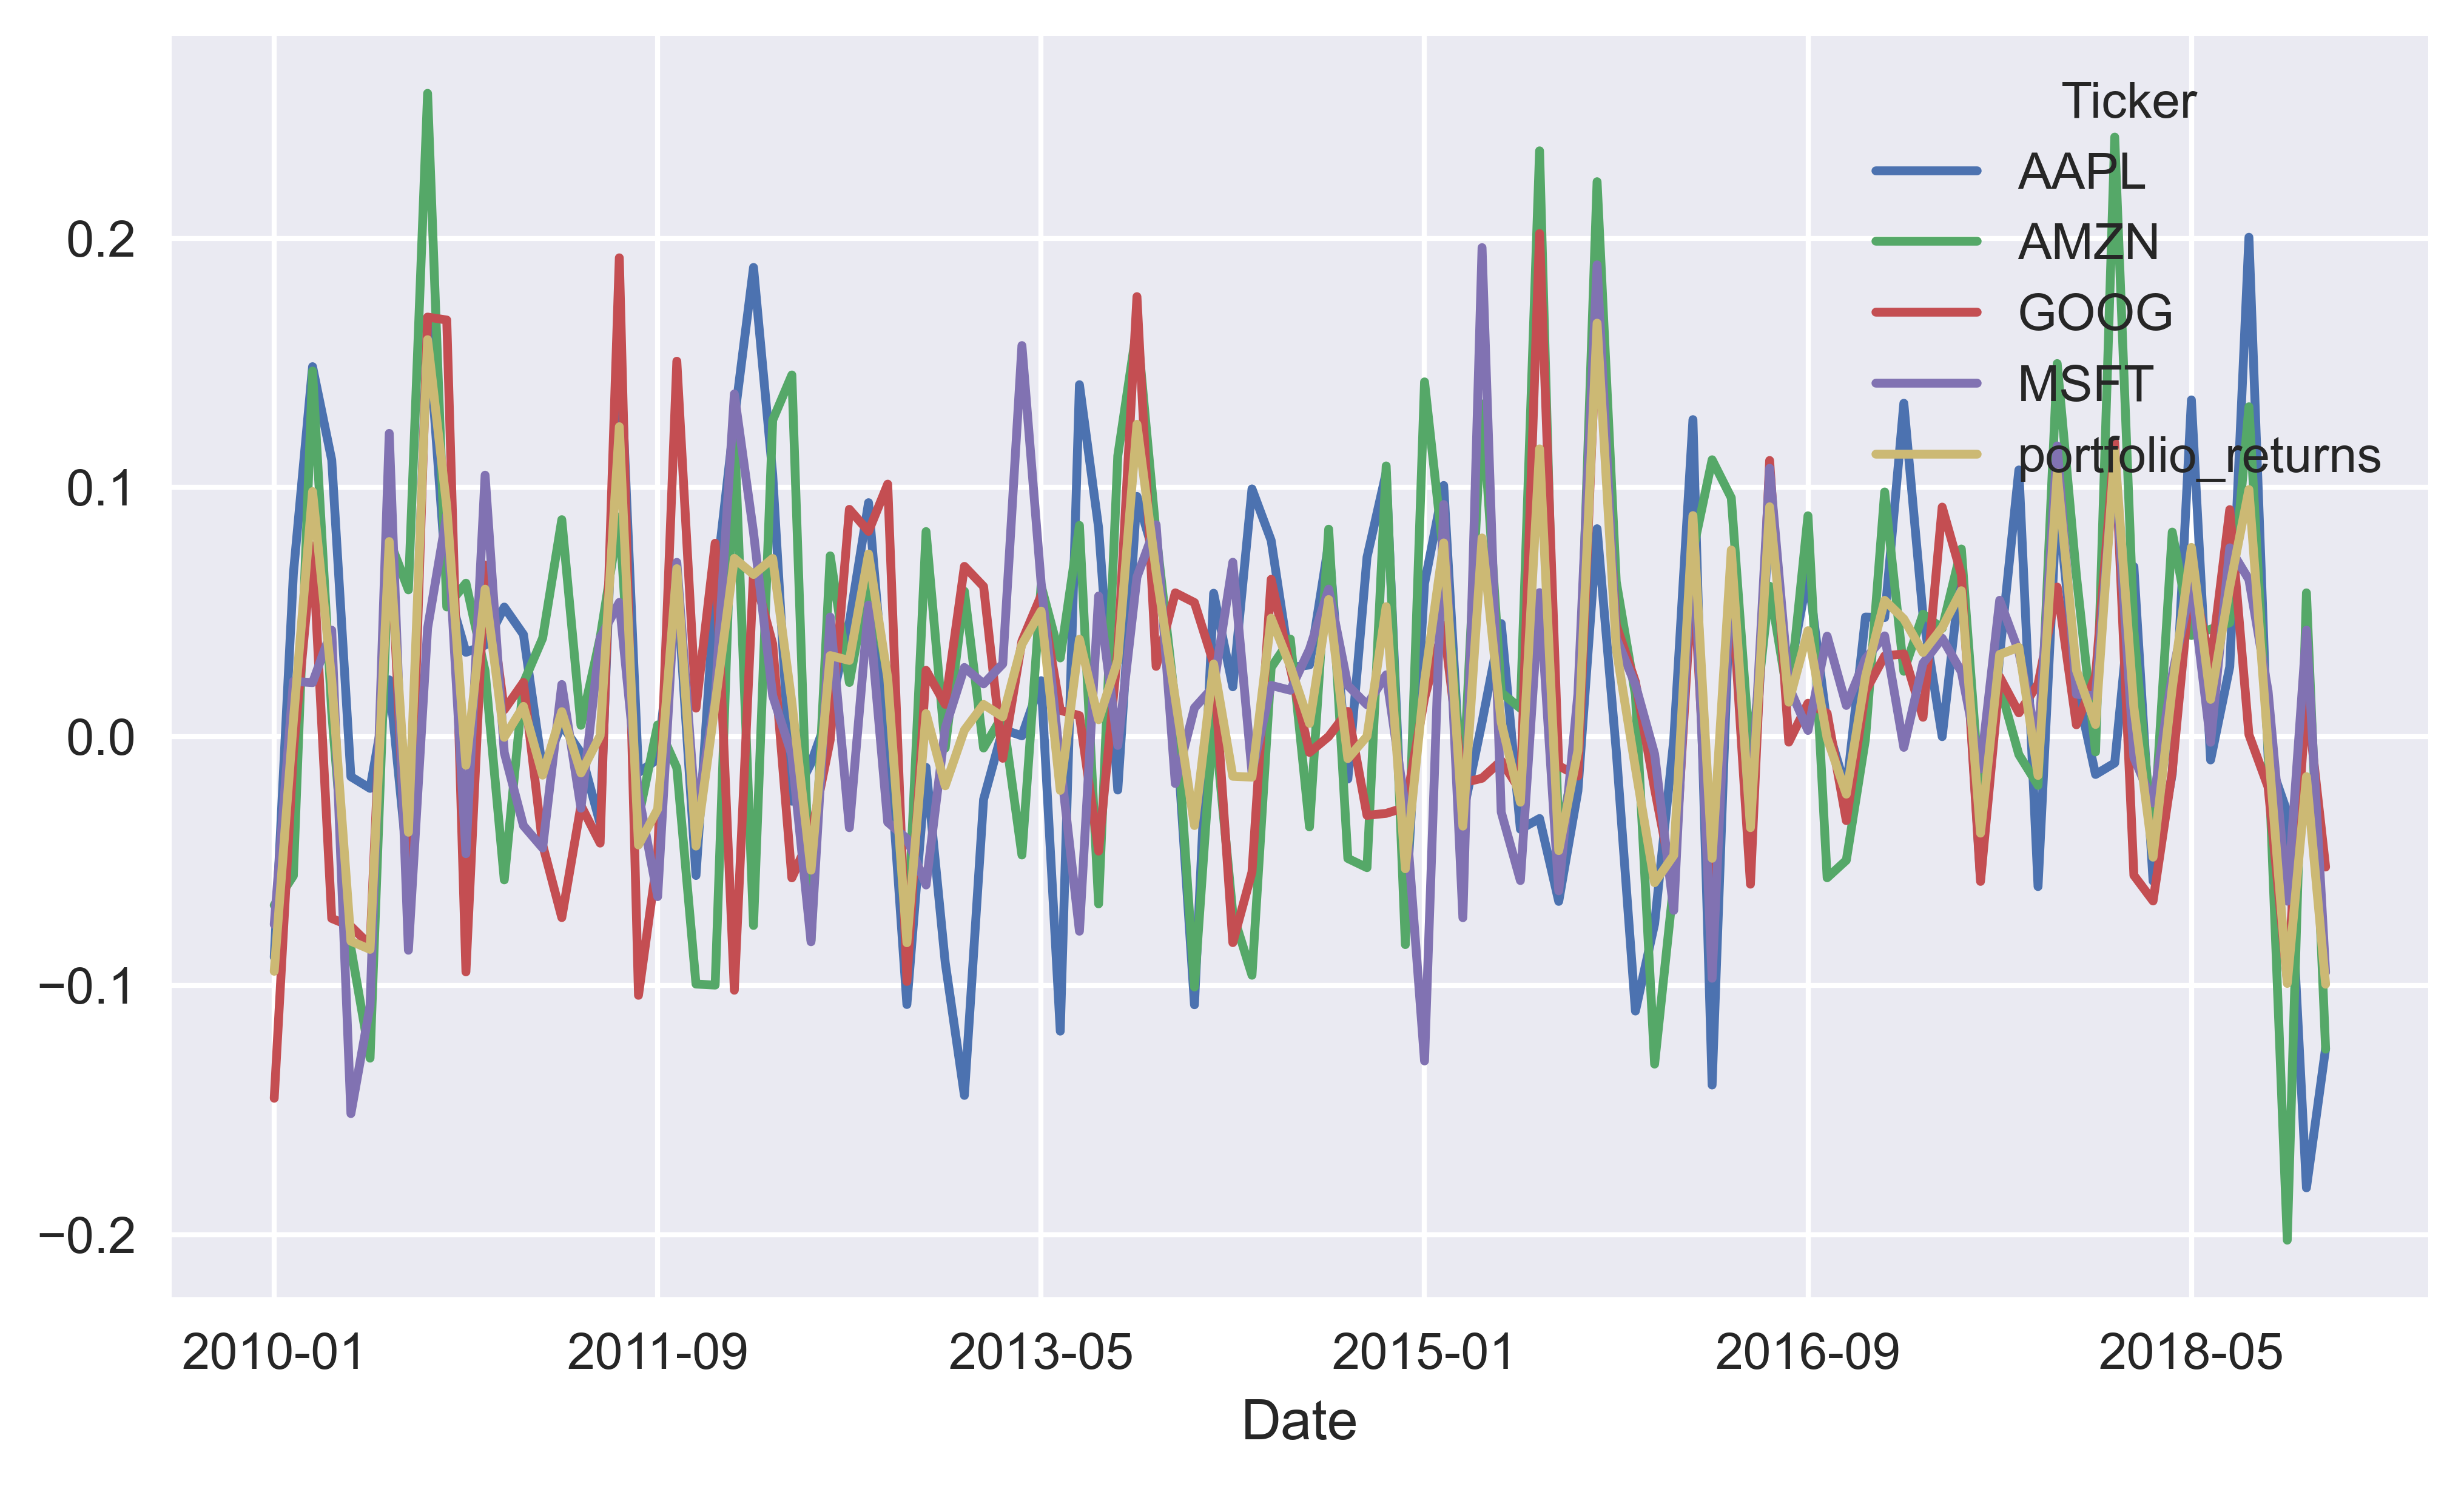

In [18]:
asset_df.plot();

7. Merge the datasets:

In [19]:
ff_data = asset_df.join(df_three_factor).drop(ASSETS, axis=1)
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data['portf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf

In [20]:
ff_data.head()

,portf_rtn,mkt,smb,hml,rf,portf_ex_rtn
Date,,,,,,
2010-01,-0.094252,-0.0336,0.0040,0.0043,0.0000,-0.094252
2010-02,0.006430,0.0340,0.0119,0.0323,0.0000,0.006430
2010-03,0.098335,0.0631,0.0148,0.0221,0.0001,0.098235
2010-04,0.022615,0.0200,0.0487,0.0289,0.0001,0.022515
2010-05,-0.082161,-0.0789,0.0009,-0.0244,0.0001,-0.082261


8. Define a function for the rolling n-factor model

In [21]:
def rolling_factor_model(input_data, formula, window_size):
    """
    Estimate the Fama-French (n-factor) model using a rolling window of fixed size.
    
    Parameters
    ----------
    input_data : pd.DataFrame
        A DataFrame containing the factors and asset/portfolio returns.
    formula : str
        `statsmodels` compatible formula representing the OLS regression.
    window_size : int
        Rolling window length.
    
    Returns
    -------
    coeffs_df : pd.DataFrame
        DataFrame containing the intercept and the factors for each iteration.
    """
    if len(input_data) < window_size:
        raise ValueError("Input data length must be greater than or equal to the window size.")
    
    coeffs = []
    
    for start_index in range(len(input_data) - window_size + 1):
        end_index = start_index + window_size
        
        # Define and fit the regression model
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_index:end_index]
        ).fit()
        
        # Store coefficients
        coeffs.append(ff_model.params)
        
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:]
    )
    
    return coeffs_df

9. Estimate the rolling three-factor model and plot the results:

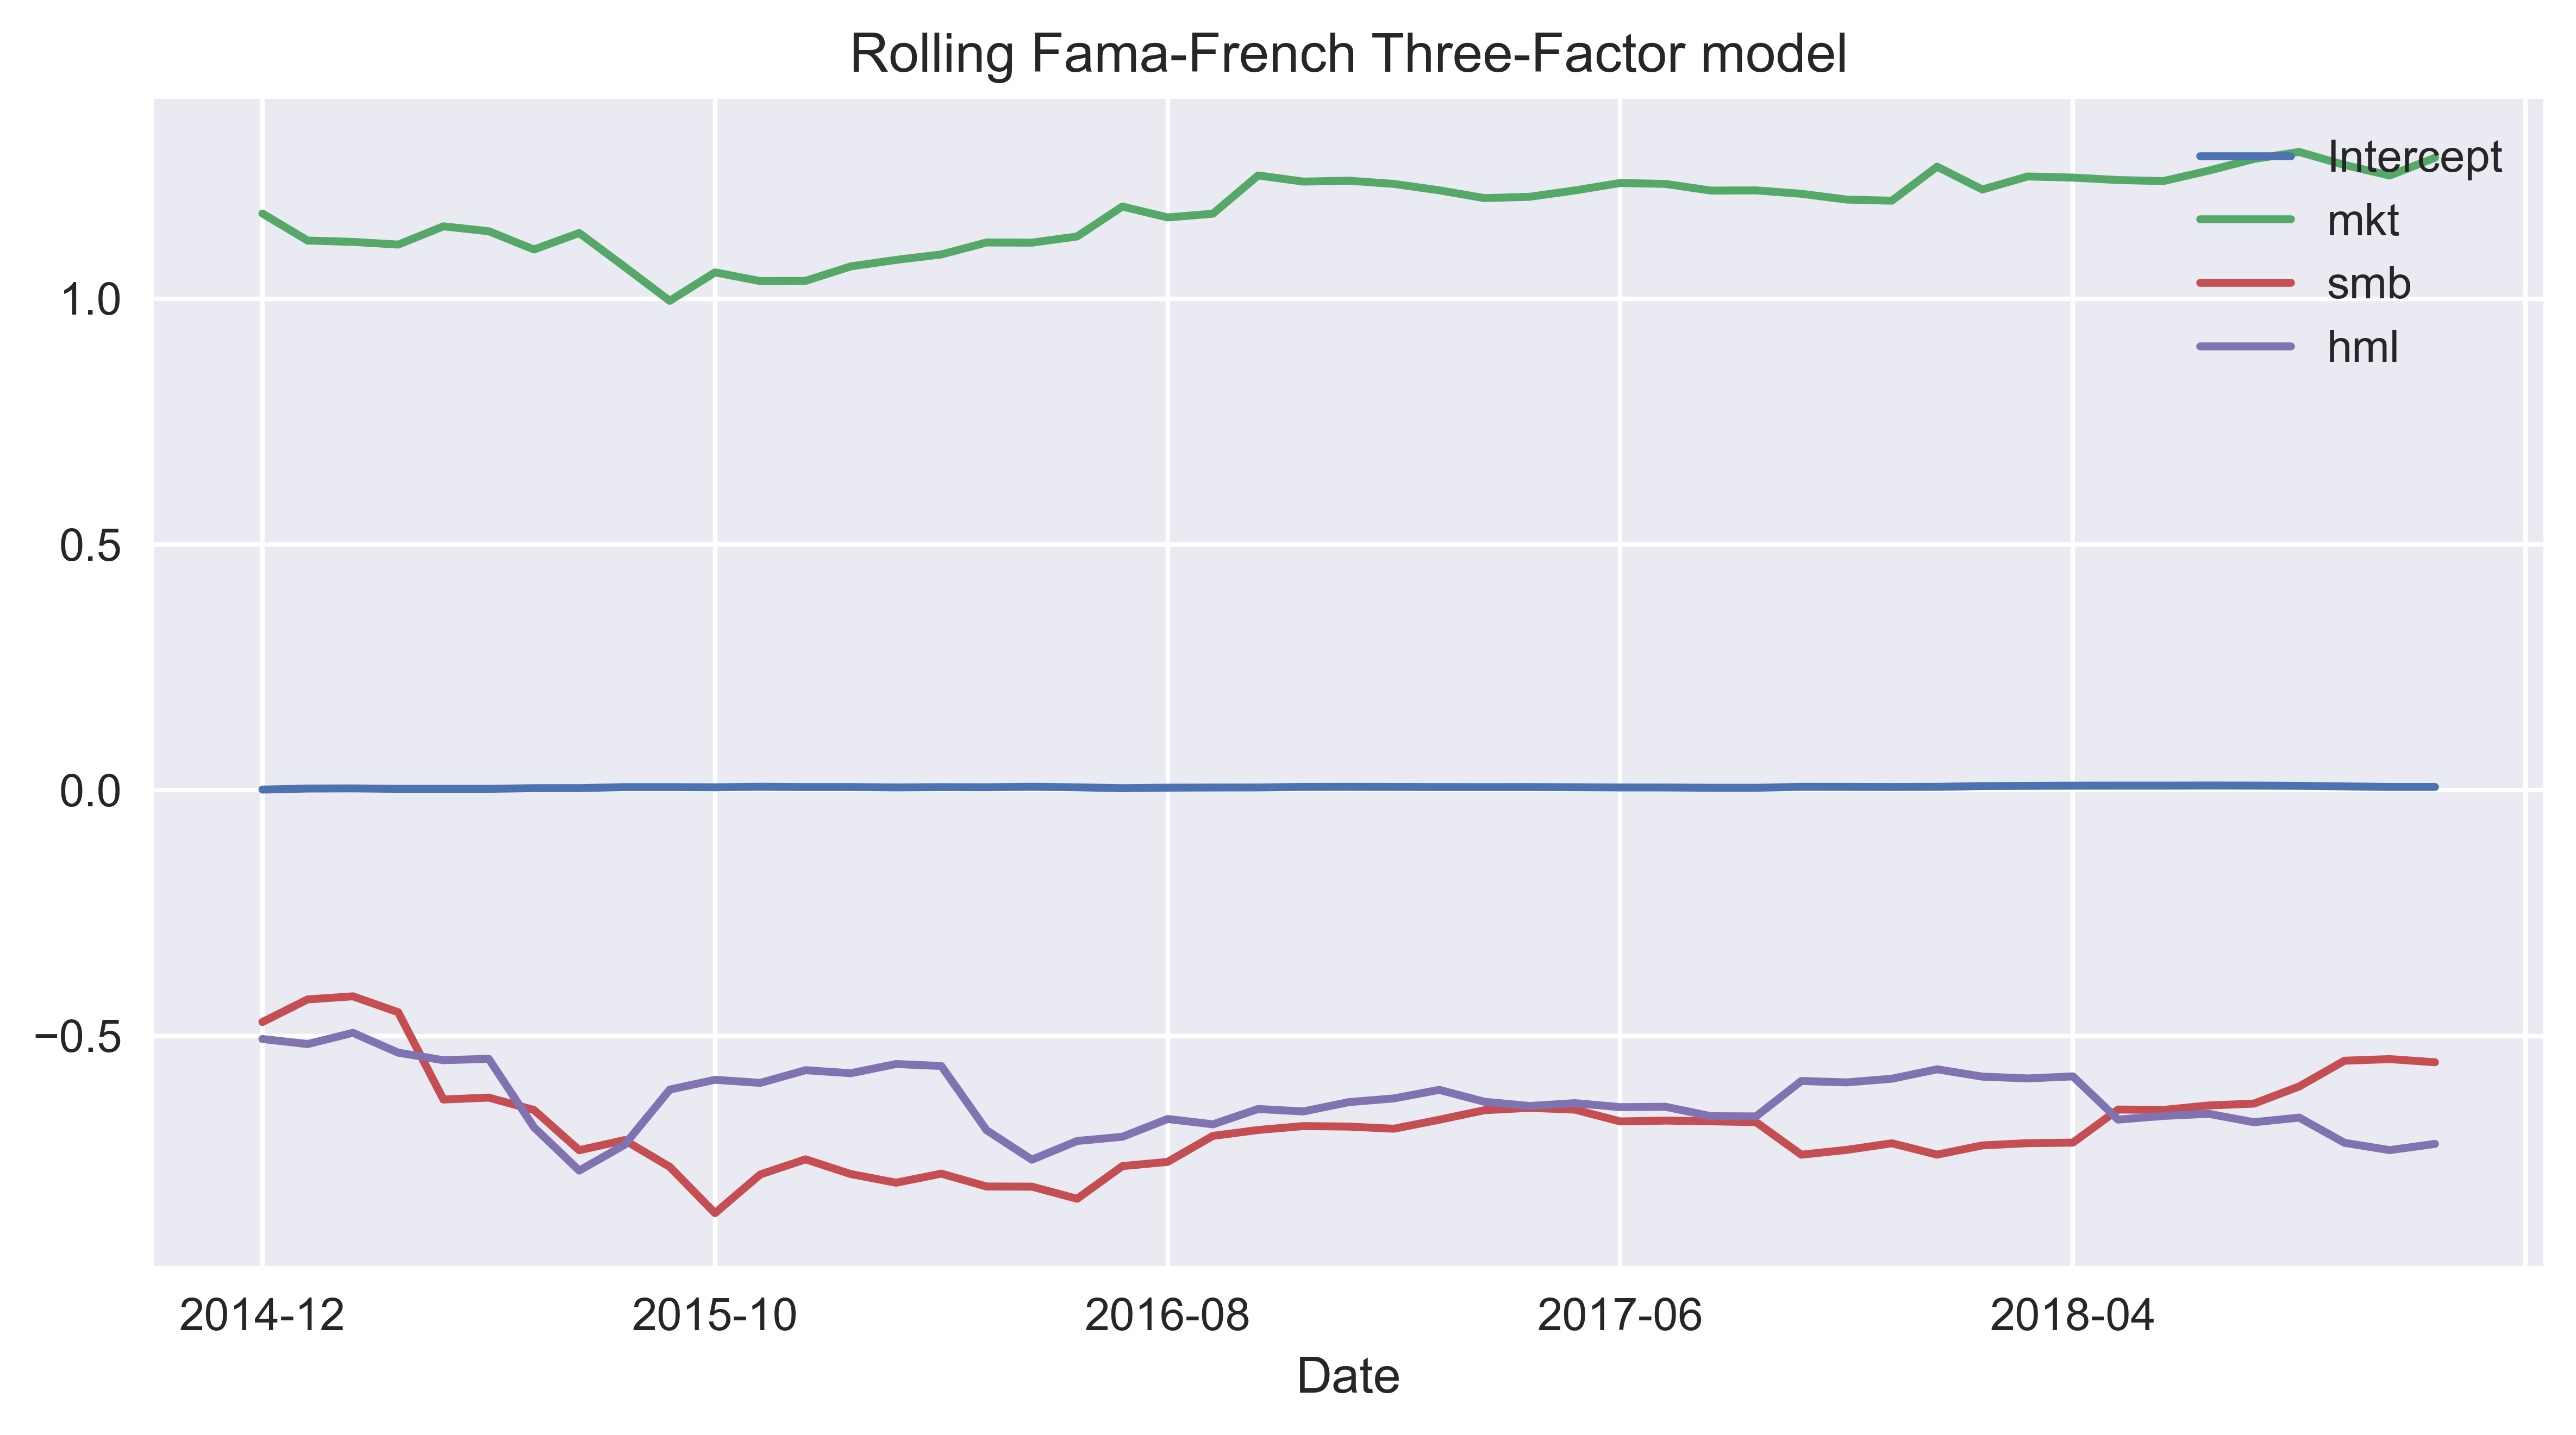

In [22]:
MODEL_FORMULA = 'portf_ex_rtn ~ mkt + smb + hml'
results_df = rolling_factor_model(ff_data, 
                                 MODEL_FORMULA, 
                                 window_size=60)
results_df.plot(title = 'Rolling Fama-French Three-Factor model')

plt.tight_layout()
plt.show()

## Implementing the four- and five-factor models in Python

In [23]:
# Constants
RISKY_ASSET = 'AMZN'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

# Fetch Fama-French Three Factors
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=START_DATE)[0]
df_three_factor.index = df_three_factor.index.format()

# Fetch Momentum Factor
df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', start=START_DATE)[0]
df_mom.index = df_mom.index.format()

# Fetch Fama-French Five Factors
df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=START_DATE)[0]
df_five_factor.index = df_five_factor.index.format()

# Download asset data
asset_df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, progress=False)

# Output the result of the download
print(f'Downloaded {asset_df.shape[0]} rows of data for {RISKY_ASSET} from {START_DATE} to {END_DATE}.')

# Displaying the first few rows to confirm data fetch
print("\nThree Factor Data:\n", df_three_factor.head())
print("\nMomentum Factor Data:\n", df_mom.head())
print("\nFive Factor Data:\n", df_five_factor.head())
print("\nAsset Data:\n", asset_df.head())

Downloaded 1258 rows of data for AMZN from 2013-12-31 to 2018-12-31.

Three Factor Data:
          Mkt-RF   SMB   HML   RF
2013-12    2.81 -0.46 -0.02  0.0
2014-01   -3.32  0.89 -2.07  0.0
2014-02    4.65  0.35 -0.31  0.0
2014-03    0.43 -1.81  4.93  0.0
2014-04   -0.19 -4.19  1.17  0.0

Momentum Factor Data:
          Mom   
2013-12    0.02
2014-01    1.71
2014-02    2.07
2014-03   -3.29
2014-04   -3.89

Five Factor Data:
          Mkt-RF   SMB   HML   RMW   CMA   RF
2013-12    2.81 -0.45 -0.02 -0.46  0.09  0.0
2014-01   -3.32  0.58 -2.07 -3.88 -1.42  0.0
2014-02    4.65  0.14 -0.31 -0.23 -0.45  0.0
2014-03    0.43 -1.09  4.93  2.13  1.92  0.0
2014-04   -0.19 -4.12  1.17  3.48  1.02  0.0

Asset Data:
                  Open     High        Low      Close  Adj Close    Volume
Date                                                                     
2013-12-31  19.729000  19.9415  19.690001  19.939501  19.939501  39930000
2014-01-02  19.940001  19.9680  19.701000  19.898500  19.898500  4

5. Calculate monthly returns:

In [24]:
y = asset_df['Adj Close'].resample('M') \
                        .last() \
                        .pct_change() \
                        .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'return'

6. Merge the datasets for the four-factor models:

In [25]:
# join all datasets on the index
four_factor_data = df_three_factor.join(df_mom).join(y)

# rename columns
four_factor_data.columns = ['mkt', 'smb', 'hml', 'rf', 'mom', 'rtn']

# divide everything (except returns) by 100
four_factor_data.loc[:, four_factor_data.columns != 'rtn'] /= 100

# select period of interest
four_factor_data = four_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
four_factor_data['excess_rtn'] = four_factor_data.rtn - four_factor_data.rf

four_factor_data.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
2014-01,-0.0332,0.0089,-0.0207,0.0,0.0171,-0.100554,-0.100554
2014-02,0.0465,0.0035,-0.0031,0.0,0.0207,0.009507,0.009507
2014-03,0.0043,-0.0181,0.0493,0.0,-0.0329,-0.071058,-0.071058
2014-04,-0.0019,-0.0419,0.0117,0.0,-0.0389,-0.095847,-0.095847
2014-05,0.0206,-0.0188,-0.0013,0.0,0.0087,0.027685,0.027685


7. Merge the datasets for the five-factor models

In [26]:
# join all datasets on the index
five_factor_data = df_five_factor.join(y)

# rename columns
five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 'rf', 'rtn']

# divide everything (except returns) by 100
five_factor_data.loc[:, five_factor_data.columns != 'rtn'] /= 100

# select period of interest
five_factor_data = five_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
five_factor_data['excess_rtn'] = five_factor_data.rtn - five_factor_data.rf

five_factor_data.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
2014-01,-0.0332,0.0058,-0.0207,-0.0388,-0.0142,0.0,-0.100554,-0.100554
2014-02,0.0465,0.0014,-0.0031,-0.0023,-0.0045,0.0,0.009507,0.009507
2014-03,0.0043,-0.0109,0.0493,0.0213,0.0192,0.0,-0.071058,-0.071058
2014-04,-0.0019,-0.0412,0.0117,0.0348,0.0102,0.0,-0.095847,-0.095847
2014-05,0.0206,-0.0189,-0.0013,0.0005,-0.0100,0.0,0.027685,0.027685


8. Estimate the four-factor model:

In [27]:
four_factor_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml + mom', 
                           data=four_factor_data).fit()

print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     16.90
Date:                Thu, 06 Jun 2024   Prob (F-statistic):           4.30e-09
Time:                        15:41:34   Log-Likelihood:                 86.372
No. Observations:                  60   AIC:                            -162.7
Df Residuals:                      55   BIC:                            -152.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0093      0.008      1.162      0.2

9. Estimate the five-factor model:

In [28]:
five_factor_model = smf.ols(
formula='excess_rtn ~ mkt + smb + hml + rmw + cma',
data=five_factor_data
).fit()

print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     15.86
Date:                Thu, 06 Jun 2024   Prob (F-statistic):           1.36e-09
Time:                        15:41:34   Log-Likelihood:                 89.429
No. Observations:                  60   AIC:                            -166.9
Df Residuals:                      54   BIC:                            -154.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0099      0.008      1.297      0.2